# Variational Autoencoder (VAE)
We test simple VAE with MNIST dataset.

#### (NOTE) The model overview
784 (28x28) dim (x)-> 256 dim (h) -> 2 dim (z: each has mean, var)-> 256dim (dh)-> 784 (28x28) dim (y).


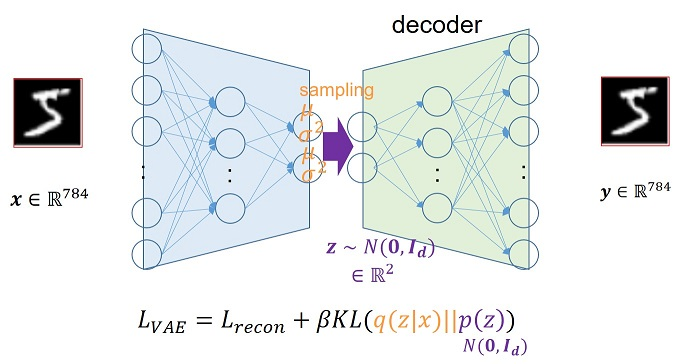

First, we import libraries and define the key parameters.

In [1]:
from __future__ import print_function

import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [2]:
# defining the key parameters
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 30
epsilon_std = 1.0

In [3]:
print(f'tensorflow version = {tf.__version__}')
print(f'keras version = {keras.__version__}')

# Countermeasures for version inconsistencies
tf.compat.v1.disable_eager_execution()

tensorflow version = 2.3.0
keras version = 2.4.3


### Definition of the sampling function. : for reparameterization-trick 
Since back-prop is not available on sampling procedure. 
We use reparameterization-trick to simulate sampling.

In [5]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Defining the encoder
The architecture of the network is basically the same with the former autoencoder.
The main difference is the each latent variable has two values, mean $\mu$ and variation $\sigma^2$.

In [6]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

### Defining the decoder 

In [7]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


### Definition of the VAE
combining the encoder and the decoder

In [8]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
# (note) z = encoder(x)[2]
#
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### Definition of the loss function

Total loss is the total of binary-cross-entropy (BCE) loss (as a reconstruction error) and the Kullback-Leibler divergence. 

$L_{total}=L_{recon}+KL(P_z(x)||N(0,I_d)) $

(note) In BCE loss, each pixel value is considered as a probability.

In [9]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### (NOTE) The model overview
784 (28x28) dim-> 256 dim -> 2 Gaussian parameters (mean, var) -> 256dim -> 768 (28x28) dim.

### Load MINST dataset 

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


### check the size and contents

In [11]:
print(F'x_train.shape {x_train.shape}')
print(F'x_test.shape {x_test.shape}')
print(F'y_train.shape {y_train.shape}')
print(F'y_test.shape {y_test.shape}')

#print(F'x_train {x_train[0:10][0:10]}')
print(F'y_train {y_train[0:10]}')


x_train.shape (60000, 784)
x_test.shape (10000, 784)
y_train.shape (60000,)
y_test.shape (10000,)
y_train [5 0 4 1 9 2 1 3 1 4]


### Train the VAE 
Takes some time. (3 - 5 minutes)

In [12]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs, 
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 130us/sample - loss: 191.3496
Epoch 2/30
60000/60000 [==============================] - 8s 132us/sample - loss: 170.7354
Epoch 3/30
60000/60000 [==============================] - 8s 131us/sample - loss: 166.0895
Epoch 4/30
60000/60000 [==============================] - 8s 132us/sample - loss: 163.1566
Epoch 5/30
60000/60000 [==============================] - 8s 133us/sample - loss: 161.1475
Epoch 6/30
60000/60000 [==============================] - 8s 133us/sample - loss: 159.6364
Epoch 7/30
60000/60000 [==============================] - 8s 133us/sample - loss: 158.4945
Epoch 8/30
60000/60000 [==============================] - 8s 133us/sample - loss: 157.5555
Epoch 9/30
60000/60000 [==============================] - 8s 133us/sample - loss: 156.7943
Epoch 10/30
60000/60000 [==============================] - 8s 132us/sample - loss: 156.1613
Epoch 11/30
60000/60000 [==============================] - 8s 131u

### Check the distribution of x_test in the latent feature space ($\mu$ in 2D)
We can see the embedding ($\mu$ in 2D) is distributed around 0. Also each number forms the cluster. 

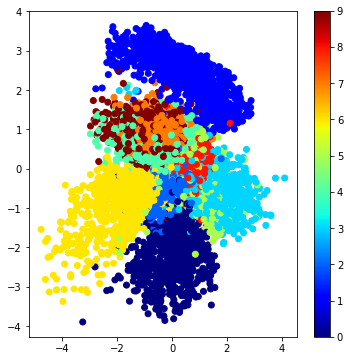

In [16]:

# display a 2D plot of the digit classes in the latent space (mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

This is the distribution of standard deviation.

In this example, weight of regularization term (KL) is not enough and therefore, the SD is much smaller than anticipated (1).

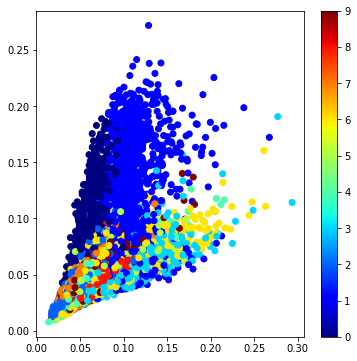

In [17]:
# display a 2D plot of the digit classes in the latent space  (SD)
x_test_encoded_SD = np.sqrt(np.exp(encoder.predict(x_test, batch_size=batch_size)[1]))
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_SD[:,0], x_test_encoded_SD[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

### Let us see the reconstructed images from the latent space

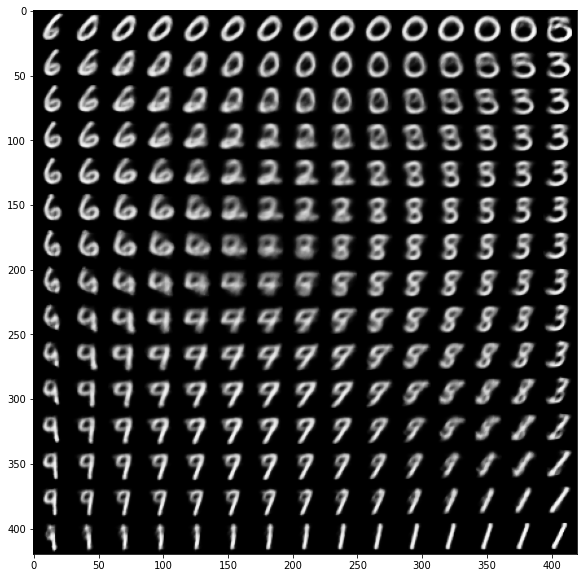

grid_x [-2.32634787e+00 -1.40507156e+00 -1.03643339e+00 -7.72193214e-01
 -5.53384720e-01 -3.58458793e-01 -1.76374165e-01 -1.39145821e-16
  1.76374165e-01  3.58458793e-01  5.53384720e-01  7.72193214e-01
  1.03643339e+00  1.40507156e+00  2.32634787e+00]


In [23]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

print(f'grid_x {grid_x}')